In [131]:
import glob
import os
from functools import partial
from multiprocessing import Manager, Pool

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord, match_coordinates_sky
from scipy.spatial import cKDTree
from tqdm import tqdm

# Paths

In [120]:
data_dir = "/arc/projects/unions/ssl/data/raw/tiles/dwarforge"
table_dir = "/arc/home/heestersnick/dwarforge/tables"
train_df = pd.read_csv(os.path.join(table_dir, "train_df.csv"))
class_df = pd.read_csv(os.path.join(table_dir, "class_df_v2.csv"))
all_dwarfs = pd.read_csv(os.path.join(table_dir, "all_known_dwarfs_v3_processed.csv"))

In [64]:
def match_coordinates(
    detected_ra, detected_dec, train_ra, train_dec, max_separation=10.0
):
    """
    Match coordinates within max_separation arcseconds
    Returns boolean array of matches and indices of matches
    """
    if len(train_ra) == 0:
        return np.zeros(len(detected_ra), dtype=bool), np.array([])

    detected_coords = SkyCoord(ra=detected_ra * u.degree, dec=detected_dec * u.degree)
    train_coords = SkyCoord(ra=train_ra * u.degree, dec=train_dec * u.degree)

    idx, sep, _ = detected_coords.match_to_catalog_sky(train_coords)
    matches = sep.arcsec <= max_separation

    return matches, idx


def process_single_file(file_path, train_df, mismatches_list):
    """
    Read and process a single parquet file, adding training flag and tracking matches
    Returns: tuple of (processed_df, match_stats)
    """
    try:
        df = pd.read_parquet(file_path)

        # Initialize match statistics for this tile
        match_stats = {
            "dwarfs_found": 0,  # objects with real IDs
            "non_dwarfs_found": 0,  # objects with non_dwarf IDs
        }

        # Extract tile from file path and add as column
        tile = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
        df["tile"] = tile

        # Initialize training flag column
        df["in_training_data"] = 0
        # Initialize expert classification
        df["visual_class"] = np.nan

        # Check if this tile exists in training data
        if tile in train_df["tile"].unique():
            # Get training data for this tile
            tile_train_data = train_df[train_df["tile"] == tile]

            # Split training data into dwarfs and non-dwarfs
            dwarfs = tile_train_data[
                ~tile_train_data["known_id"].str.startswith("non_dwarf", na=False)
            ]
            non_dwarfs = tile_train_data[
                tile_train_data["known_id"].str.startswith("non_dwarf", na=False)
            ]

            # Process dwarf objects
            if len(dwarfs) > 0:
                dwarf_matches, dwarf_idx = match_coordinates(
                    df["ra"].values,
                    df["dec"].values,
                    dwarfs["ra"].values,
                    dwarfs["dec"].values,
                )
                df.loc[dwarf_matches, "in_training_data"] = 1
                # Add visual classification for matched objects
                df.loc[dwarf_matches, "visual_class"] = dwarfs.iloc[
                    dwarf_idx[dwarf_matches]
                ]["label"].values
                match_stats["dwarfs_found"] = np.count_nonzero(dwarf_matches)

                # Check ID matches for dwarfs
                coord_matched_indices = np.where(dwarf_matches)[0]
                for _, train_obj in dwarfs.iterrows():
                    id_matches = df["ID_known"] == train_obj["known_id"]
                    id_matched_indices = np.where(id_matches)[0]

                    if len(id_matched_indices) > 1:
                        print(
                            f"\nFound multiple matches for ID {train_obj['known_id']} in tile {tile}"
                        )
                        print(f"Found in rows: {id_matched_indices}")

                    matched_by_coords = any(
                        i in coord_matched_indices for i in id_matched_indices
                    )

                    if not matched_by_coords or (len(id_matched_indices) == 0):
                        mismatches_list.append(
                            {
                                "train_id": train_obj["known_id"],
                                "train_ra": train_obj["ra"],
                                "train_dec": train_obj["dec"],
                                "train_tile": tile,
                                "coord_matched": matched_by_coords,
                                "id_matched": len(id_matched_indices) > 0,
                                "n_id_matches": len(id_matched_indices),
                            }
                        )

            # Process non-dwarf objects
            if len(non_dwarfs) > 0:
                non_dwarf_matches, non_dwarf_idx = match_coordinates(
                    df["ra"].values,
                    df["dec"].values,
                    non_dwarfs["ra"].values,
                    non_dwarfs["dec"].values,
                )
                df.loc[non_dwarf_matches, "in_training_data"] = 1
                # df.loc[non_dwarf_matches, 'ID_known'] = non_dwarfs.iloc[non_dwarf_idx[non_dwarf_matches]]['known_id'].values
                # Add visual classification for matched objects
                df.loc[non_dwarf_matches, "visual_class"] = non_dwarfs.iloc[
                    non_dwarf_idx[non_dwarf_matches]
                ]["label"].values
                match_stats["non_dwarfs_found"] = np.count_nonzero(non_dwarf_matches)

        return df, match_stats

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return pd.DataFrame(), {"dwarfs_found": 0, "non_dwarfs_found": 0}


def gather_data(base_dir, train_df, num_processes=4):
    """
    Gather data from all parquet files and track mismatches
    """
    # Create the pattern to match the parquet files
    pattern = os.path.join(base_dir, "*_*", "gri", "*_matched_detections.parquet")

    # Get list of all matching files
    parquet_files = glob.glob(pattern)

    if not parquet_files:
        raise ValueError(f"No parquet files found matching pattern: {pattern}")

    print(f"Found {len(parquet_files)} parquet files")

    # Create manager for sharing mismatches list between processes
    with Manager() as manager:
        mismatches_list = manager.list()

        # Create partial function with train_df and mismatches_list
        process_file = partial(
            process_single_file, train_df=train_df, mismatches_list=mismatches_list
        )

        # Process files with progress bar
        dfs = []
        total_dwarfs_found = 0
        total_non_dwarfs_found = 0

        with Pool(processes=num_processes) as pool:
            for df, stats in tqdm(
                pool.imap(process_file, parquet_files),
                total=len(parquet_files),
                desc="Processing files",
                unit="file",
            ):
                dfs.append(df)
                total_dwarfs_found += stats["dwarfs_found"]
                total_non_dwarfs_found += stats["non_dwarfs_found"]

        # Convert mismatches list to DataFrame
        mismatches_df = pd.DataFrame(list(mismatches_list))

    print("\nCombining dataframes...")
    combined_df = pd.concat(dfs, ignore_index=True)

    # Get total counts from training set
    dwarfs = train_df[~train_df["known_id"].str.startswith("non_dwarf", na=False)]
    non_dwarfs = train_df[train_df["known_id"].str.startswith("non_dwarf", na=False)]

    print("\nTraining object statistics:")
    print(f"Dwarfs (objects with real IDs):")
    print(f"  - Total in training set: {len(dwarfs)}")
    print(f"  - Found in results: {total_dwarfs_found}")
    print(f"  - Missing: {len(dwarfs) - total_dwarfs_found}")

    print(f"\nNon-dwarfs:")
    print(f"  - Total in training set: {len(non_dwarfs)}")
    print(f"  - Found in results: {total_non_dwarfs_found}")
    print(f"  - Missing: {len(non_dwarfs) - total_non_dwarfs_found}")

    return combined_df, mismatches_df


def count_intervals(values):
    # Create bins from 0 to 1 with 0.05 intervals
    bins = np.arange(0, 1.05, 0.05)

    # Use numpy's histogram function
    counts, _ = np.histogram(values, bins=bins)

    # Print the counts for each interval
    for i in range(len(counts)):
        start = round(bins[i], 2)
        end = round(bins[i + 1], 2)
        print(f"{start:.2f} - {end:.2f}: {counts[i]}")

    return counts

# Gather all data

In [76]:
# Process all files
result_df, mismatch_df = gather_data(data_dir, class_df, num_processes=16)

# Save the combined dataset
# result_df.to_parquet("unions_lsb_catalog_all.parquet")

print(f"Combined shape: {result_df.shape}")
print(f"Number of training objects: {result_df['in_training_data'].sum()}")

Found 16516 parquet files


Processing files:  16%|█▌        | 2605/16516 [00:08<00:59, 233.71file/s]


Found multiple matches for ID d0934p70 in tile 098_320
Found in rows: [260 343]


Processing files: 100%|██████████| 16516/16516 [00:53<00:00, 307.41file/s]



Combining dataframes...

Training object statistics:
Dwarfs (objects with real IDs):
  - Total in training set: 1998
  - Found in results: 1992
  - Missing: 6

Non-dwarfs:
  - Total in training set: 1465
  - Found in results: 1458
  - Missing: 7
Combined shape: (1535052, 108)
Number of training objects: 3448


In [77]:
mismatch_df

,train_id,train_ra,train_dec,train_tile,coord_matched,id_matched,n_id_matches
0,134804.64+433350.8,206.99060,43.586876,300_267,False,False,0
1,142153.6+502950,215.44012,50.505850,274_281,False,False,0
2,1234502+293314,188.70910,29.553762,328_239,False,True,1
3,dw1315p4304,198.75896,43.100273,291_266,False,True,1
4,NGC5474,211.25569,53.662277,251_287,False,True,1
5,ddo82,157.64590,70.621120,105_321,False,True,1
6,dw0846p3300,131.55559,33.000023,221_246,False,True,1
7,dw1350p5441,207.73068,54.686382,241_289,False,True,1


In [68]:
non_na = result_df[result_df["ID_known"].notna()].reset_index(drop=True)

In [71]:
non_na[non_na["ID_known"].str.startswith("1.24")]

,unique_id,ra,dec,class_label,zspec,lsb,ID_known,ID_cfis_lsb-r,X_cfis_lsb-r,Y_cfis_lsb-r,...,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,zoobot_pred_v2,tile,in_training_data,visual_class
20,8,206.990661,43.586842,NaN,NaN,1.0,1.24E+18,371.0,544.4103,1670.9567,...,6.615252,6.346136,0.959319,20.706983,26.928783,0.985576,0.996846,300_267,1,1.0
259,29,215.440118,50.505853,2.0,0.048125,1.0,1.24E+18,908.0,1071.2705,1277.7982,...,7.259335,4.320461,0.595159,20.162413,25.301271,0.979995,0.993476,274_281,1,1.0


In [55]:
missing = class_df[~class_df["known_id"].isin(result_df["ID_known"])].reset_index(
    drop=True
)

In [56]:
len(result_df[result_df["ID_known"].notna()]["ID_known"])

3542

In [57]:
missing[missing["known_id"].str.startswith("non_dwarf")]

,known_id,ra,dec,tile,label
4,non_dwarf_48,188.37973,74.033270,104_328,0.0
5,non_dwarf_94,160.35579,70.190870,110_320,0.0
6,non_dwarf_1029,206.62668,60.371710,204_301,0.0
7,non_dwarf_1244,140.72412,40.083076,216_260,0.0
8,non_dwarf_1503,198.75896,43.100273,291_266,0.0
9,non_dwarf_2576,131.31969,49.928574,169_280,0.0
10,non_dwarf_2793,159.16770,50.494514,203_281,0.0


In [22]:
result_df[result_df["ID_known"] == "1234502+293314"]

,unique_id,ra,dec,class_label,zspec,lsb,ID_known,ID_cfis_lsb-r,X_cfis_lsb-r,Y_cfis_lsb-r,...,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,zoobot_pred_v2,tile,in_training_data,visual_class
514831,31,188.705054,29.550547,NaN,NaN,1.0,1234502+293314,NaN,NaN,NaN,...,25.785701,18.654065,0.723427,20.001187,27.68615,0.035895,0.466594,328_239,0,NaN


In [58]:
result_df[result_df["ID_known"].notna()]

,unique_id,ra,dec,class_label,zspec,lsb,ID_known,ID_cfis_lsb-r,X_cfis_lsb-r,Y_cfis_lsb-r,...,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,zoobot_pred_v2,tile,in_training_data,visual_class
27,27,165.165606,29.706097,2.0,0.002801,1.0,1100400+294225,1978.0,26.98333,2249.4016,...,12.456587,6.004730,0.482053,19.840847,25.984714,0.969128,0.985477,287_239,0,NaN
498,40,138.616215,79.139076,2.0,0.082016,1.0,091427+790820,1119.0,1492.31430,1923.7168,...,4.703980,2.558000,0.543795,20.866514,24.940408,0.986740,0.994125,053_338,1,1.000000
504,46,138.277294,79.207952,NaN,NaN,1.0,091306+791228,1352.0,1798.24050,2259.6980,...,3.241510,1.892487,0.583829,22.281819,25.209013,0.675656,0.897944,053_338,1,0.875000
565,107,138.483322,79.246391,NaN,NaN,1.0,0913561+791448,NaN,NaN,NaN,...,6.017702,2.805230,0.466163,22.857942,26.838480,0.946872,0.993701,053_338,1,1.000000
4730,31,167.528797,46.502388,NaN,NaN,1.0,1110070+463010,1116.0,2125.19870,1262.3988,...,6.420168,4.360901,0.679250,22.074293,25.489932,0.634473,0.869338,231_273,1,0.958333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531131,28,136.988993,46.023786,2.0,0.494622,NaN,non_dwarf_2702,955.0,471.88060,1365.7389,...,2.726511,2.086100,0.765117,22.440734,25.661533,0.000059,0.003946,190_272,1,0.000000
1531166,63,136.902937,45.809107,NaN,NaN,NaN,non_dwarf_2703,NaN,NaN,NaN,...,2.069784,1.679042,0.811216,23.667581,26.685763,0.032215,0.010531,190_272,1,0.000000
1531167,64,136.911740,45.813171,NaN,NaN,NaN,non_dwarf_2704,NaN,NaN,NaN,...,2.402885,2.119525,0.882075,23.700559,27.249892,0.000279,0.004354,190_272,1,0.000000
1531168,65,137.014748,45.820404,NaN,NaN,NaN,non_dwarf_855,NaN,NaN,NaN,...,2.338495,1.201309,0.513710,23.027418,25.487496,0.000078,0.004563,190_272,1,0.000000


In [27]:
# remove objects that were used to train the model
# result_no_train = result_df[(result_df['in_training_data'] == 0) & (result_df['lsb'].isna())].reset_index(drop=True)
# save to file
# result_no_train.to_parquet(os.path.join(table_dir, 'combined_no_train.parquet'), index=False)
# remove rows with nan predictions
result_df = result_df[~result_df["zoobot_pred_v2"].isna()].reset_index(drop=True)

In [79]:
result_df[result_df["zoobot_pred"].isna()]

,unique_id,ra,dec,class_label,zspec,lsb,ID_known,ID_cfis_lsb-r,X_cfis_lsb-r,Y_cfis_lsb-r,...,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,zoobot_pred_v2,tile,in_training_data,visual_class


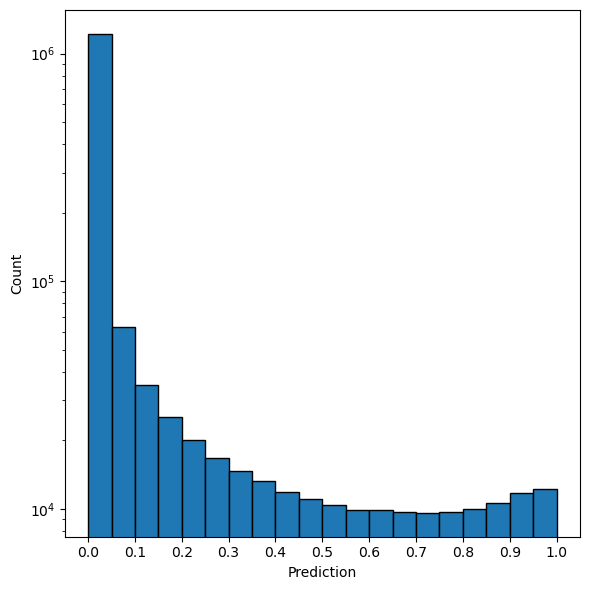

In [80]:
plt.figure(figsize=(6, 6))
plt.hist(result_df["zoobot_pred_v2"], bins=np.arange(0, 1.05, 0.05), ec="black")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Prediction")
plt.ylabel("Count")
plt.yscale("log")
plt.tight_layout()
# plt.savefig(os.path.join(figures, 'prediction_dist_example.png'), dpi=300, bbox_inches='tight')
plt.show()

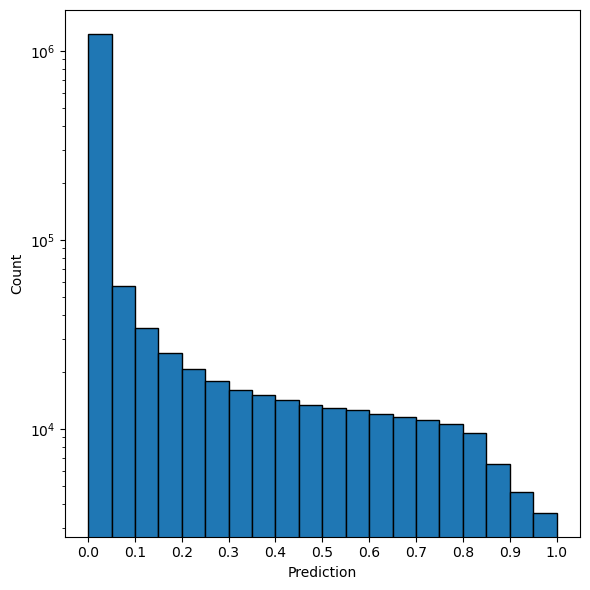

In [81]:
plt.figure(figsize=(6, 6))
plt.hist(result_df["zoobot_pred"], bins=np.arange(0, 1.05, 0.05), ec="black")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Prediction")
plt.ylabel("Count")
plt.yscale("log")
plt.tight_layout()
# plt.savefig(os.path.join(figures, 'prediction_dist_example.png'), dpi=300, bbox_inches='tight')
plt.show()

In [82]:
# print counts in 0.05 bins from 0 to 1
counts = count_intervals(result_df["zoobot_pred_v2"].values)

0.00 - 0.05: 1220044
0.05 - 0.10: 63016
0.10 - 0.15: 35210
0.15 - 0.20: 25267
0.20 - 0.25: 20015
0.25 - 0.30: 16711
0.30 - 0.35: 14695
0.35 - 0.40: 13245
0.40 - 0.45: 11892
0.45 - 0.50: 11071
0.50 - 0.55: 10361
0.55 - 0.60: 9932
0.60 - 0.65: 9905
0.65 - 0.70: 9654
0.70 - 0.75: 9622
0.75 - 0.80: 9738
0.80 - 0.85: 10025
0.85 - 0.90: 10654
0.90 - 0.95: 11754
0.95 - 1.00: 12241


In [83]:
def analyze_string_matches(arr1, arr2):
    valid_strings = set(arr2)

    # Initialize counters
    matches = 0
    nones = 0
    nans = 0
    non_matches = 0
    non_matches_list = []
    matches_list = []

    for x in arr1:
        if x is None:
            nones += 1
        elif isinstance(x, float) and np.isnan(x):
            nans += 1
        elif x in valid_strings:
            matches += 1
            matches_list.append(x)
        else:
            non_matches += 1
            non_matches_list.append(x)

    print(f"Matches: {matches}")
    print(f"None values: {nones}")
    print(f"NaN values: {nans}")
    print(f"Non-matching strings: {non_matches}")

    return matches_list, non_matches_list

In [84]:
matches, non_matches = analyze_string_matches(
    result_df["ID_known"], class_df["known_id"]
)

Matches: 2070
None values: 134106
NaN values: 1398859
Non-matching strings: 17


In [104]:
result_df[result_df["ID_known"] == non_matches[16]]

,unique_id,ra,dec,class_label,zspec,lsb,ID_known,ID_cfis_lsb-r,X_cfis_lsb-r,Y_cfis_lsb-r,...,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,zoobot_pred_v2,tile,in_training_data,visual_class
1401078,16,182.970248,29.327149,NaN,NaN,1.0,1211528+291937,466.0,2466.5305,413.45218,...,3.09768,1.695767,0.547431,23.171502,26.629636,0.598313,0.803108,319_239,0,NaN


# Remove duplicates

In [215]:
def remove_duplicates(df, max_separation_arcsec=10.0, priority_column="zoobot_pred"):
    """
    Remove duplicate entries from the DataFrame using Friends-of-Friends clustering.
    Returns both deduplicated DataFrame and groups DataFrame for inspection.
    """
    # Convert RA/Dec to SkyCoord
    coords = SkyCoord(ra=df["ra"].values * u.degree, dec=df["dec"].values * u.degree)

    # Convert to 3D Cartesian coordinates on the unit sphere
    x = np.cos(coords.dec.radian) * np.cos(coords.ra.radian)
    y = np.cos(coords.dec.radian) * np.sin(coords.ra.radian)
    z = np.sin(coords.dec.radian)
    points = np.column_stack((x, y, z))

    # Compute maximum chord length for clustering
    max_angle_rad = (max_separation_arcsec * u.arcsec).to(u.radian).value
    max_chord_length = 2 * np.sin(max_angle_rad / 2)

    # Build KD-tree for efficient neighbor search
    tree = cKDTree(points)

    # Find all pairs within the threshold distance
    pairs = tree.query_pairs(max_chord_length, output_type="set")

    # Union-Find to create clusters
    parent = np.arange(len(df))

    def find(node):
        while parent[node] != node:
            parent[node] = parent[parent[node]]  # Path compression
            node = parent[node]
        return node

    for node1, node2 in pairs:
        root1 = find(node1)
        root2 = find(node2)
        if root1 != root2:
            parent[root2] = root1

    # Assign cluster labels
    cluster_labels = np.array([find(i) for i in range(len(parent))])
    df = df.copy()
    df["_cluster"] = cluster_labels

    # Create groups information
    groups_info = []
    same_tile_duplicates = 0
    overlap_duplicates = 0

    # Process each cluster with more than one object
    for cluster_id in tqdm(np.unique(cluster_labels), desc="Processing clusters"):
        cluster_mask = cluster_labels == cluster_id
        if np.sum(cluster_mask) > 1:  # Only process groups with multiple objects
            cluster_objects = df[cluster_mask]
            best_idx = cluster_objects[priority_column].idxmax()

            # Count duplicate types
            unique_tiles = cluster_objects["tile"].unique()
            if len(unique_tiles) == 1:
                same_tile_duplicates += len(cluster_objects) - 1
            else:
                overlap_duplicates += len(cluster_objects) - 1

            # Calculate separations from best object
            best_coord = SkyCoord(
                ra=df.loc[best_idx, "ra"] * u.degree,
                dec=df.loc[best_idx, "dec"] * u.degree,
            )

            # Add information for each object in the cluster
            for idx, row in cluster_objects.iterrows():
                obj_coord = SkyCoord(ra=row["ra"] * u.degree, dec=row["dec"] * u.degree)
                sep_to_best = obj_coord.separation(best_coord).arcsec

                groups_info.append(
                    {
                        "cluster_id": cluster_id,
                        "object_id": idx,
                        "ra": row["ra"],
                        "dec": row["dec"],
                        "tile": row["tile"],
                        "separation_to_best": sep_to_best,
                        f"{priority_column}": row[priority_column],
                        "is_best": idx == best_idx,
                        "duplicate_type": (
                            "same_tile" if len(unique_tiles) == 1 else "overlap"
                        ),
                    }
                )

    # Create groups DataFrame
    groups_df = pd.DataFrame(groups_info)

    # Print summary
    total_duplicates = same_tile_duplicates + overlap_duplicates
    print("\nDuplicate Detection Summary:")
    print(f"Total objects in input: {len(df)}")
    print(f"Total duplicate objects found: {total_duplicates}")
    print(f"  - Same tile duplicates: {same_tile_duplicates}")
    print(f"  - Tile overlap duplicates: {overlap_duplicates}")
    print(f"Objects after deduplication: {len(df) - total_duplicates}")

    # Select best entry in each cluster
    dedup_df = df.loc[df.groupby("_cluster")[priority_column].idxmax()]
    dedup_df = dedup_df.drop(columns=["_cluster"]).reset_index(drop=True)

    return dedup_df, groups_df

In [87]:
# deduped_catalog, group_cat = remove_duplicates(result_no_train, max_separation_arcsec=10.0)

# save to file
deduped_catalog.to_parquet(
    os.path.join(table_dir, "combined_no_dups.parquet"), index=False
)
# group_cat.to_parquet(os.path.join(table_dir, 'duplicate_groups.parquet'), index=False)

In [94]:
# print counts in 0.05 bins from 0 to 1
counts = count_intervals(deduped_catalog["zoobot_pred"].values)

0.00 - 0.05: 1178978
0.05 - 0.10: 54716
0.10 - 0.15: 32706
0.15 - 0.20: 24025
0.20 - 0.25: 19636
0.25 - 0.30: 17166
0.30 - 0.35: 15365
0.35 - 0.40: 14336
0.40 - 0.45: 13527
0.45 - 0.50: 12789
0.50 - 0.55: 12345
0.55 - 0.60: 11946
0.60 - 0.65: 11364
0.65 - 0.70: 11002
0.70 - 0.75: 10626
0.75 - 0.80: 10087
0.80 - 0.85: 9082
0.85 - 0.90: 6122
0.90 - 0.95: 4258
0.95 - 1.00: 2910


In [98]:
counts[-4:]

array([9082, 6122, 4258, 2910])

In [88]:
# First get unique cluster IDs where at least one object has high prediction score
high_score_clusters = group_cat[group_cat["zoobot_pred"] > 0.8]["cluster_id"].unique()

# Then look at all objects in these clusters
for cluster_id in high_score_clusters[:20]:
    group = group_cat[group_cat["cluster_id"] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print("Number of objects in group:", len(group))
    print(group[["ra", "dec", "tile", "zoobot_pred", "duplicate_type"]])
    print("-" * 80)


Cluster 34:
Number of objects in group: 2
           ra        dec     tile  zoobot_pred duplicate_type
6  256.773954  30.262967  443_241     0.641872        overlap
7  256.773960  30.262925  442_241     0.815979        overlap
--------------------------------------------------------------------------------

Cluster 550:
Number of objects in group: 2
            ra        dec     tile  zoobot_pred duplicate_type
77  137.561796  79.164205  053_338     0.838378        overlap
78  137.562691  79.164109  052_338     0.882683        overlap
--------------------------------------------------------------------------------

Cluster 1919:
Number of objects in group: 2
             ra        dec     tile  zoobot_pred duplicate_type
308  142.816922  73.081679  084_326     0.836562        overlap
309  142.816790  73.081618  083_326     0.593395        overlap
--------------------------------------------------------------------------------

Cluster 2050:
Number of objects in group: 2
             

In [89]:
not_known = deduped_catalog[
    deduped_catalog["class_label"].isna() & deduped_catalog["zspec"].isna()
].reset_index(drop=True)

In [90]:
not_known

,unique_id,ra,dec,class_label,zspec,lsb,ID_known,ID_cfis_lsb-r,X_cfis_lsb-r,Y_cfis_lsb-r,...,r_90_arcsec_ps-i,r_100_arcsec_ps-i,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,tile,in_training_data
0,0,164.875234,29.255025,NaN,NaN,NaN,None,60.0,1248.89310,62.524967,...,3.887821,4.834848,2.152427,1.690427,0.785359,22.530605,25.825963,0.014323,287_239,0
1,1,165.070683,29.271613,NaN,NaN,NaN,None,137.0,422.89352,143.584500,...,3.999242,4.907014,2.915492,1.719423,0.589754,22.659902,25.772148,0.000103,287_239,0
2,3,164.599668,29.335794,NaN,NaN,NaN,None,498.0,2412.74780,455.208620,...,9.532401,10.964404,8.423223,6.767626,0.803448,21.636005,27.196714,0.000123,287_239,0
3,4,164.775681,29.341711,NaN,NaN,NaN,None,527.0,1669.33290,482.683500,...,3.819408,4.456524,2.610384,1.829996,0.701045,23.355706,26.770033,0.011025,287_239,0
4,5,164.676088,29.465065,NaN,NaN,NaN,None,1004.0,2088.91500,1080.840600,...,4.649535,6.075285,2.345340,1.966709,0.838560,21.801385,25.373376,0.000286,287_239,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151665,143,153.121514,72.712180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.743097,5.943675,3.238213,1.968451,0.607882,22.559488,25.704605,0.003090,092_325,0
1151666,144,152.769797,72.713068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.405877,3.932768,3.046045,2.015368,0.661634,24.523559,27.719697,0.008306,092_325,0
1151667,145,153.359094,72.716444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.436761,5.134553,3.538931,2.320163,0.655611,23.483086,26.928146,0.002864,092_325,0
1151668,146,153.282833,72.715529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.416909,5.417703,2.774803,2.413583,0.869821,23.239391,26.813021,0.031284,092_325,0


In [91]:
# save to file
not_known.to_parquet(os.path.join(table_dir, "combined_unknown.parquet"), index=False)

In [397]:
deduped_catalog[deduped_catalog["zoobot_pred"] > 0.7][:15]

,unique_id,ra,dec,class_label,zspec,lsb,ID_known,ID_cfis_lsb-r,X_cfis_lsb-r,Y_cfis_lsb-r,...,r_90_arcsec_ps-i,r_100_arcsec_ps-i,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,tile,in_training_data
15,15,164.658123,29.597392,NaN,NaN,NaN,None,1530.0,2163.49780,1722.070800,...,6.218253,7.188374,4.605558,2.708196,0.588028,22.404829,26.665720,0.792634,287_239,0
23,23,165.025730,29.671339,2.0,0.073501,NaN,None,1824.0,615.38200,2079.881000,...,5.973173,7.522895,3.353184,3.003653,0.895761,21.637103,25.893669,0.821762,287_239,0
34,4,256.773960,30.262925,NaN,NaN,NaN,NaN,126.0,64.70447,102.278275,...,4.192345,4.924890,2.297889,2.130173,0.927013,23.635609,27.388887,0.815979,442_241,0
35,6,256.790406,30.267614,2.0,0.077304,NaN,NaN,129.0,2424.11430,124.968360,...,6.508269,9.242195,3.523674,2.505530,0.711056,21.021999,24.764068,0.701574,443_241,0
45,16,256.997450,30.351901,NaN,NaN,NaN,NaN,496.0,1557.49700,531.972700,...,4.213255,5.134553,2.270151,1.797581,0.791833,22.992458,26.502197,0.938553,443_241,0
52,23,257.210132,30.366417,2.0,0.199754,NaN,NaN,619.0,668.41846,602.553600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.739955,443_241,0
56,27,257.077520,30.402722,2.0,0.037206,NaN,NaN,689.0,1222.76100,778.086240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.779021,443_241,0
125,9,236.852925,45.338646,NaN,NaN,NaN,NaN,432.0,1189.08220,467.662450,...,5.869283,7.151604,4.194526,2.356994,0.561921,22.507886,26.320219,0.844257,332_271,0
144,28,236.500192,45.496225,NaN,NaN,NaN,NaN,1145.0,2387.11910,1233.459000,...,4.995756,7.464258,2.895553,1.868457,0.645285,21.108473,24.630768,0.705366,332_271,0
236,21,156.256517,47.841924,2.0,0.063828,NaN,NaN,341.0,977.15200,483.683650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.724275,209_276,0


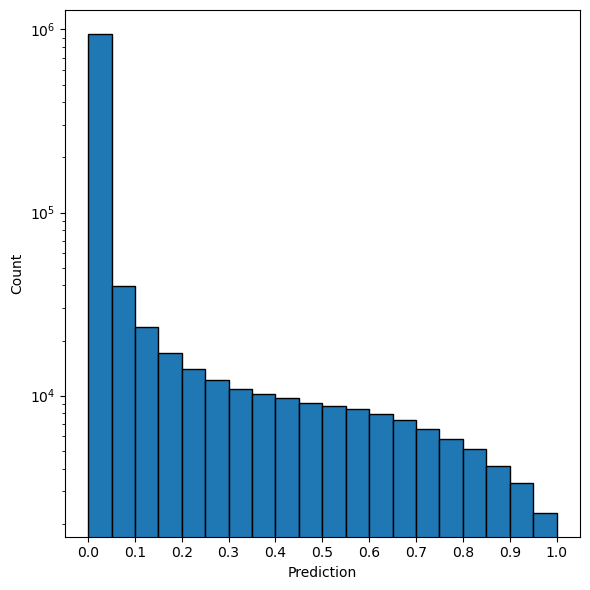

In [92]:
plt.figure(figsize=(6, 6))
plt.hist(not_known["zoobot_pred"], bins=np.arange(0, 1.05, 0.05), ec="black")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Prediction")
plt.ylabel("Count")
plt.yscale("log")
plt.tight_layout()
# plt.savefig(os.path.join(figures, 'prediction_dist_example.png'), dpi=300, bbox_inches='tight')
plt.show()

In [100]:
# print counts in 0.05 bins from 0 to 1
counts = count_intervals(not_known["zoobot_pred"].values)

0.00 - 0.05: 945136
0.05 - 0.10: 39893
0.10 - 0.15: 23651
0.15 - 0.20: 17157
0.20 - 0.25: 13965
0.25 - 0.30: 12143
0.30 - 0.35: 10868
0.35 - 0.40: 10221
0.40 - 0.45: 9662
0.45 - 0.50: 9126
0.50 - 0.55: 8820
0.55 - 0.60: 8486
0.60 - 0.65: 7944
0.65 - 0.70: 7394
0.70 - 0.75: 6559
0.75 - 0.80: 5768
0.80 - 0.85: 5089
0.85 - 0.90: 4154
0.90 - 0.95: 3340
0.95 - 1.00: 2294


In [101]:
sum(counts[-4:])

14877

In [434]:
not_known[(not_known["zoobot_pred"] > 0.8) & (not_known["zoobot_pred"] < 1)]

,unique_id,ra,dec,class_label,zspec,lsb,ID_known,ID_cfis_lsb-r,X_cfis_lsb-r,Y_cfis_lsb-r,...,r_90_arcsec_ps-i,r_100_arcsec_ps-i,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,tile,in_training_data
27,4,256.773960,30.262925,NaN,NaN,NaN,NaN,126.0,64.70447,102.278275,...,4.192345,4.924890,2.297889,2.130173,0.927013,23.635609,27.388887,0.815979,442_241,0
35,16,256.997450,30.351901,NaN,NaN,NaN,NaN,496.0,1557.49700,531.972700,...,4.213255,5.134553,2.270151,1.797581,0.791833,22.992458,26.502197,0.938553,443_241,0
93,9,236.852925,45.338646,NaN,NaN,NaN,NaN,432.0,1189.08220,467.662450,...,5.869283,7.151604,4.194526,2.356994,0.561921,22.507886,26.320219,0.844257,332_271,0
180,26,156.140420,47.837481,NaN,NaN,NaN,NaN,432.0,1354.67370,462.032560,...,5.319489,6.426743,4.621414,2.114362,0.457514,22.555741,25.922544,0.978910,209_276,0
209,64,155.931884,48.047881,NaN,NaN,NaN,NaN,1268.0,2029.64160,1482.566200,...,7.428854,9.449066,5.538753,2.865521,0.517358,21.403122,25.510987,0.950639,209_276,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151540,4,152.830959,72.660506,NaN,NaN,NaN,NaN,82.0,1455.09990,2027.229500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.849551,092_325,0
1151542,6,153.169490,72.686664,NaN,NaN,NaN,NaN,140.0,966.70996,2154.178700,...,6.089733,7.707532,4.500763,2.052042,0.455932,21.897563,25.560543,0.860110,092_325,0
1151593,64,152.757233,72.370680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.798358,5.839261,2.844882,2.084006,0.732546,22.808602,26.635972,0.882899,092_325,0
1151611,85,152.356869,72.444699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.107642,4.816638,3.539488,1.405640,0.397131,23.493142,26.290438,0.839343,092_325,0


# Remove duplicates based on effective radius

In [175]:
def remove_duplicates(
    df, radius_factor=1.5, min_separation=1.0, priority_column="zoobot_pred_v2"
):
    """
    Remove duplicates using KD-tree with effective radius-based filtering.

    Parameters:
    - df: DataFrame containing astronomical objects
    - radius_factor: Factor to multiply effective radius by for threshold
    - min_separation: Minimum separation to use when r_eff is very small/nan
    - priority_column: Column used to select which duplicate to keep

    Returns:
    - dedup_df: Deduplicated DataFrame
    - groups_df: DataFrame containing information about duplicate groups
    """
    # Calculate maximum effective radius for each object
    df = df.copy()
    df["max_r_eff"] = df.apply(
        lambda row: max(
            [
                row["re_arcsec_cfis_lsb-r"],
                row["re_arcsec_whigs-g"],
                row["re_arcsec_ps-i"],
            ],
            default=min_separation,
        ),
        axis=1,
    )
    df["max_r_eff"] = df["max_r_eff"].fillna(min_separation)

    # Use maximum possible threshold for KD-tree initial search
    max_possible_threshold = df["max_r_eff"].max() * radius_factor
    print(f"Maximum search threshold: {max_possible_threshold:.2f} arcsec")

    # Convert coordinates to 3D Cartesian
    coords = SkyCoord(ra=df["ra"].values * u.degree, dec=df["dec"].values * u.degree)
    x = np.cos(coords.dec.radian) * np.cos(coords.ra.radian)
    y = np.cos(coords.dec.radian) * np.sin(coords.ra.radian)
    z = np.sin(coords.dec.radian)
    points = np.column_stack((x, y, z))

    # Set up KD-tree with maximum possible threshold
    max_angle_rad = (max_possible_threshold * u.arcsec).to(u.radian).value
    max_chord_length = 2 * np.sin(max_angle_rad / 2)
    tree = cKDTree(points)

    # Get initial pairs from KD-tree
    pairs = tree.query_pairs(max_chord_length, output_type="set")

    # Vectorized filtering of pairs
    filtered_pairs = set()
    if pairs:  # Only process if pairs were found
        pairs_array = np.array(list(pairs))
        i, j = pairs_array.T
        r_eff1 = df["max_r_eff"].values[i]
        r_eff2 = df["max_r_eff"].values[j]
        max_r_eff = np.maximum(r_eff1, r_eff2)
        separations = coords[i].separation(coords[j]).arcsec

        # Apply condition
        mask = separations <= max_r_eff * radius_factor
        filtered_pairs = set(map(tuple, pairs_array[mask]))

        # Store separations for groups information
        df["pair_separation"] = np.nan
        df.loc[pairs_array[mask][:, 0], "pair_separation"] = separations[mask]

    # Efficient Union-Find implementation
    parent = np.arange(len(df))

    def find(node):
        if parent[node] != node:
            parent[node] = find(parent[node])  # Path compression
        return parent[node]

    # Group filtered pairs
    for node1, node2 in filtered_pairs:
        root1 = find(node1)
        root2 = find(node2)
        if root1 != root2:
            parent[root2] = root1

    # Assign cluster labels more efficiently
    cluster_labels = np.array([find(i) for i in range(len(parent))])
    df["_cluster"] = cluster_labels

    # Pre-calculate unique clusters and their sizes
    unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)
    multi_object_clusters = unique_clusters[cluster_counts > 1]

    # Initialize arrays for groups information
    groups_info = []
    same_tile_duplicates = 0
    overlap_duplicates = 0

    # Process clusters with multiple objects
    for cluster_id in tqdm(multi_object_clusters, desc="Processing clusters"):
        cluster_mask = cluster_labels == cluster_id
        cluster_objects = df[cluster_mask]
        best_idx = cluster_objects[priority_column].idxmax()

        # Count duplicate types
        unique_tiles = cluster_objects["tile"].unique()
        if len(unique_tiles) == 1:
            same_tile_duplicates += len(cluster_objects) - 1
        else:
            overlap_duplicates += len(cluster_objects) - 1

        # Vectorized separation calculation
        best_coord = SkyCoord(
            ra=df.loc[best_idx, "ra"] * u.degree, dec=df.loc[best_idx, "dec"] * u.degree
        )

        cluster_coords = SkyCoord(
            ra=cluster_objects["ra"].values * u.degree,
            dec=cluster_objects["dec"].values * u.degree,
        )
        separations = best_coord.separation(cluster_coords).arcsec

        # Add information for each object in cluster
        for (idx, row), sep in zip(cluster_objects.iterrows(), separations):
            groups_info.append(
                {
                    "cluster_id": cluster_id,
                    "object_id": idx,
                    "ra": row["ra"],
                    "dec": row["dec"],
                    "tile": row["tile"],
                    "max_r_eff": row["max_r_eff"],
                    "separation_to_best": sep,
                    f"{priority_column}": row[priority_column],
                    "is_best": idx == best_idx,
                    "duplicate_type": (
                        "same_tile" if len(unique_tiles) == 1 else "overlap"
                    ),
                    "threshold_used": row["max_r_eff"] * radius_factor,
                }
            )

    # Create groups DataFrame
    groups_df = pd.DataFrame(groups_info)

    # Calculate total duplicates
    total_duplicates = same_tile_duplicates + overlap_duplicates

    # Print summary
    print("\nDuplicate Detection Summary:")
    print(f"Total objects in input: {len(df)}")
    print(f"Total duplicate objects found: {total_duplicates}")
    print(f"  - Same tile duplicates: {same_tile_duplicates}")
    print(f"  - Tile overlap duplicates: {overlap_duplicates}")
    print(f"Objects after deduplication: {len(df) - total_duplicates}")

    # Select best entry in each cluster
    dedup_df = df.loc[df.groupby("_cluster")[priority_column].idxmax()]
    dedup_df = dedup_df.drop(
        columns=["_cluster", "max_r_eff", "pair_separation"]
    ).reset_index(drop=True)

    return dedup_df, groups_df

In [176]:
dedup_df, groups_df = remove_duplicates(result_df)

Maximum search threshold: 82.19 arcsec


Processing clusters: 100%|██████████| 54505/54505 [03:04<00:00, 294.68it/s]



Duplicate Detection Summary:
Total objects in input: 1535052
Total duplicate objects found: 56319
  - Same tile duplicates: 960
  - Tile overlap duplicates: 55359
Objects after deduplication: 1478733


In [177]:
result_df[result_df["zoobot_pred_v2"].isna()]

,unique_id,ra,dec,class_label,zspec,lsb,ID_known,ID_cfis_lsb-r,X_cfis_lsb-r,Y_cfis_lsb-r,...,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,zoobot_pred_v2,tile,in_training_data,visual_class


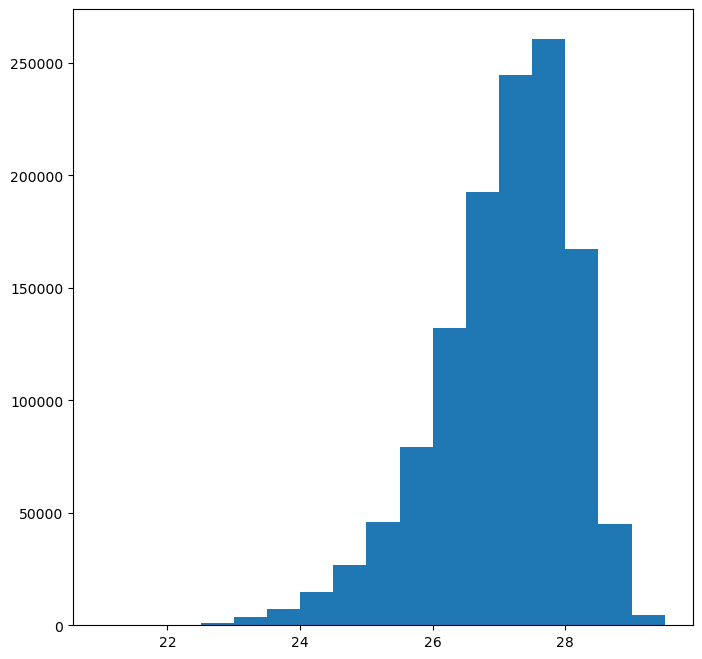

In [108]:
plt.figure(figsize=(8, 8))
plt.hist(dedup_df["mu_whigs-g"], bins=np.arange(21, 30, 0.5))
plt.show()

In [268]:
# First get unique cluster IDs where at least one object has high prediction score
groups_same_tile = groups_df[groups_df["duplicate_type"] == "same_tile"]
high_score_clusters = groups_same_tile[groups_same_tile["zoobot_pred"] > 0.6][
    "cluster_id"
].unique()

# Then look at all objects in these clusters
for cluster_id in high_score_clusters[:50]:
    group = groups_same_tile[groups_same_tile["cluster_id"] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print("Number of objects in group:", len(group))
    print(group[["ra", "dec", "tile", "zoobot_pred", "duplicate_type"]])
    print("-" * 80)


Cluster 6811:
Number of objects in group: 7
              ra        dec     tile  zoobot_pred duplicate_type
1015  187.180836  43.215653  274_266     0.179635      same_tile
1016  187.172044  43.220267  274_266     0.414146      same_tile
1017  187.179393  43.218442  274_266     0.417114      same_tile
1018  187.170636  43.227624  274_266     0.656468      same_tile
1019  187.188890  43.233520  274_266     0.643808      same_tile
1020  187.185953  43.223136  274_266     0.581966      same_tile
1021  187.200430  43.224757  274_266     0.022074      same_tile
--------------------------------------------------------------------------------

Cluster 13807:
Number of objects in group: 2
              ra        dec     tile  zoobot_pred duplicate_type
1994  139.004579  52.841908  167_286     0.706835      same_tile
1995  139.013008  52.841943  167_286     0.734133      same_tile
--------------------------------------------------------------------------------

Cluster 158481:
Number of objec

In [178]:
# print counts in 0.05 bins from 0 to 1
counts = count_intervals(dedup_df["zoobot_pred_v2"].values)

0.00 - 0.05: 1176597
0.05 - 0.10: 60271
0.10 - 0.15: 33702
0.15 - 0.20: 24251
0.20 - 0.25: 19172
0.25 - 0.30: 16005
0.30 - 0.35: 14066
0.35 - 0.40: 12737
0.40 - 0.45: 11395
0.45 - 0.50: 10655
0.50 - 0.55: 9980
0.55 - 0.60: 9533
0.60 - 0.65: 9524
0.65 - 0.70: 9295
0.70 - 0.75: 9233
0.75 - 0.80: 9352
0.80 - 0.85: 9669
0.85 - 0.90: 10224
0.90 - 0.95: 11325
0.95 - 1.00: 11747


In [179]:
sum(counts[-4:])

42965

In [271]:
no_train_dedup = dedup_df[
    (dedup_df["in_training_data"] == 0) & (dedup_df["lsb"].isna())
].reset_index(drop=True)
not_known = no_train_dedup[
    no_train_dedup["class_label"].isna() & no_train_dedup["zspec"].isna()
].reset_index(drop=True)

In [182]:
# print counts in 0.05 bins from 0 to 1
counts = count_intervals(dedup_df["zoobot_pred"].values)

0.00 - 0.05: 1183447
0.05 - 0.10: 54626
0.10 - 0.15: 32612
0.15 - 0.20: 24040
0.20 - 0.25: 19637
0.25 - 0.30: 17170
0.30 - 0.35: 15360
0.35 - 0.40: 14351
0.40 - 0.45: 13532
0.45 - 0.50: 12856
0.50 - 0.55: 12379
0.55 - 0.60: 12011
0.60 - 0.65: 11440
0.65 - 0.70: 11087
0.70 - 0.75: 10719
0.75 - 0.80: 10168
0.80 - 0.85: 9177
0.85 - 0.90: 6233
0.90 - 0.95: 4432
0.95 - 1.00: 3456


In [193]:
sum(counts[-4:])

23298

In [194]:
dedup_filled.to_parquet(os.path.join(table_dir, "unions_master_v3.parquet"), index=False)
# groups_df.to_parquet(os.path.join(table_dir, 'duplicate_groups.parquet'), index=False)
# not_known.to_parquet(os.path.join(table_dir, 'combined_unknown.parquet'), index=False)
# no_train_dedup.to_parquet(os.path.join(table_dir, 'no_train_no_duplicates.parquet'), index=False)

In [196]:
len(dedup_filled)

1478733

In [198]:
np.count_nonzero(dedup_filled["ID_known"].notna())

2028

In [121]:
dedup_df.head()

,unique_id,ra,dec,class_label,zspec,lsb,ID_known,ID_cfis_lsb-r,X_cfis_lsb-r,Y_cfis_lsb-r,...,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,zoobot_pred_v2,tile,in_training_data,visual_class
0,0,164.875234,29.255025,NaN,NaN,NaN,None,60.0,1248.89310,62.524967,...,2.152427,1.690427,0.785359,22.530605,25.825963,0.014323,0.119680,287_239,0,NaN
1,1,165.070683,29.271613,NaN,NaN,NaN,None,137.0,422.89352,143.584500,...,2.915492,1.719423,0.589754,22.659902,25.772148,0.000103,0.003690,287_239,0,NaN
2,2,164.698423,29.284181,3.0,0.156996,NaN,None,229.0,1996.03220,204.347800,...,3.801009,2.940329,0.773565,20.971540,24.908574,0.000228,0.013776,287_239,0,NaN
3,3,164.599668,29.335794,NaN,NaN,NaN,None,498.0,2412.74780,455.208620,...,8.423223,6.767626,0.803448,21.636005,27.196714,0.000123,0.004619,287_239,0,NaN
4,4,164.775681,29.341711,NaN,NaN,NaN,None,527.0,1669.33290,482.683500,...,2.610384,1.829996,0.701045,23.355706,26.770033,0.011025,0.154989,287_239,0,NaN


### Add missing IDs for dwarfs that were in multiple tiles

In [186]:
def fill_missing_ids(
    df_target: pd.DataFrame,
    df_catalog: pd.DataFrame,
    ra_col: str = "ra",
    dec_col: str = "dec",
    id_col_target: str = "ID_known",
    id_col_catalog: str = "ID",
    tolerance_arcsec: float = 10.0,
    coord_frame: str = "icrs",
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Fills missing IDs in a target DataFrame by cross-matching with a catalog.

    Matches based on celestial coordinates (RA, Dec) within a specified tolerance.
    Modifies the target DataFrame in place.

    Args:
        df_target: DataFrame to fill missing IDs in. Assumed to have NaN/None
                   for missing values in the target ID column.
        df_catalog: Catalog DataFrame with coordinates and IDs to match against.
        ra_col: Name of the Right Ascension column (in decimal degrees).
        dec_col: Name of the Declination column (in decimal degrees).
        id_col_target: Name of the ID column in df_target to check and fill.
        id_col_catalog: Name of the ID column in df_catalog to use for filling.
        tolerance_arcsec: Matching tolerance in arcseconds.
        coord_frame: Astropy coordinate frame (e.g., 'icrs', 'galactic').
        verbose: If True, print status messages.

    Returns:
        The modified df_target DataFrame (modified in place).
    """
    # 1. Identify rows in the target DataFrame with missing IDs
    df_target = df_target.copy()
    missing_mask = df_target[id_col_target].isna()
    df_target_missing = df_target.loc[missing_mask]

    if df_target_missing.empty:
        if verbose:
            print("No missing IDs found in the target DataFrame.")
        return df_target

    if verbose:
        print(f"Found {len(df_target_missing)} rows with missing IDs.")

    # 2. Create Astropy SkyCoord objects
    try:
        coords_target = SkyCoord(
            ra=df_target_missing[ra_col].values * u.degree,
            dec=df_target_missing[dec_col].values * u.degree,
            frame=coord_frame,
        )
        coords_catalog = SkyCoord(
            ra=df_catalog[ra_col].values * u.degree,
            dec=df_catalog[dec_col].values * u.degree,
            frame=coord_frame,
        )
    except KeyError as e:
        print(f"Error: Column not found - {e}. Check column names.")
        return df_target  # Return unmodified df on error
    except Exception as e:
        print(f"Error creating SkyCoord objects: {e}")
        return df_target

    # 3. Perform cross-matching
    # idx: index *in coords_catalog* of the nearest neighbor
    # sep2d: on-sky separation
    idx, sep2d, _ = match_coordinates_sky(coords_target, coords_catalog)

    # 4. Filter matches by tolerance
    tolerance = tolerance_arcsec * u.arcsec
    valid_match_mask = sep2d <= tolerance

    # 5. Get indices and IDs for update
    # Indices in the *original* df_target corresponding to successful matches
    df_target_indices_to_update = df_target_missing.index[valid_match_mask]
    # Indices in df_catalog for the matched objects
    df_catalog_indices_for_ids = idx[valid_match_mask]

    if len(df_target_indices_to_update) > 0:
        # Get the actual IDs from the catalog to fill in
        ids_to_fill = df_catalog.loc[df_catalog_indices_for_ids, id_col_catalog].values

        # 6. Update df_target (in place) using .loc
        df_target.loc[df_target_indices_to_update, id_col_target] = ids_to_fill
        if verbose:
            print(f"Successfully updated {len(df_target_indices_to_update)} IDs.")
    elif verbose:
        print(f"No matches found within the {tolerance_arcsec} arcsec tolerance.")

    return df_target

In [187]:
dedup_filled = fill_missing_ids(df_target=dedup_df, df_catalog=all_dwarfs)

Found 1476747 rows with missing IDs.
Successfully updated 42 IDs.


In [189]:
np.count_nonzero(dedup_df['ID_known'].notna()), np.count_nonzero(dedup_filled['ID_known'].notna())

(1986, 2028)

In [140]:
dedup_filled[dedup_filled['ID_known'].notna()][100:150]

,unique_id,ra,dec,class_label,zspec,lsb,ID_known,ID_cfis_lsb-r,X_cfis_lsb-r,Y_cfis_lsb-r,...,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,zoobot_pred_v2,tile,in_training_data,visual_class
61004,11,138.107619,34.863574,2.0,0.047182,1.0,MATLAS-471,474.0,612.982360,588.93110,...,4.354439,3.013541,0.692062,20.639745,25.063494,0.980389,0.994509,226_250,1,1.000000
61027,34,138.198225,35.159275,2.0,0.023266,1.0,MATLAS-476,1698.0,256.397770,2022.27330,...,6.643618,5.242463,0.789098,20.139632,25.898648,0.954729,0.994117,226_250,1,1.000000
61032,39,138.219858,35.186951,NaN,NaN,1.0,0912528+351112,1819.0,171.077770,2156.58600,...,NaN,NaN,NaN,NaN,NaN,0.264655,0.726350,226_250,1,0.666667
61033,40,138.138796,35.192031,NaN,0.005407,1.0,MATLAS-473,1847.0,492.093660,2180.44970,...,2.691992,1.709445,0.635011,22.864634,26.338918,0.729686,0.750101,226_250,1,0.750000
61037,44,137.763203,35.216248,NaN,0.005907,1.0,MATLAS-466,1927.0,1978.953100,2297.72050,...,7.513062,5.536965,0.736979,20.734709,26.588916,0.808602,0.942442,226_250,1,1.000000
61421,23,169.831122,51.837410,NaN,NaN,1.0,1119193+515014,567.0,965.028600,461.85403,...,NaN,NaN,NaN,NaN,NaN,0.735366,0.892565,209_284,1,0.791667
62187,9,137.927184,35.308177,NaN,NaN,1.0,0911425+351830,274.0,2275.708500,321.38440,...,4.578379,2.801935,0.611993,23.082266,27.237564,0.899706,0.969639,225_251,1,1.000000
62217,39,138.321468,35.549424,NaN,NaN,1.0,MATLAS-482,1662.0,718.458200,1489.18590,...,4.116269,3.096697,0.752307,21.452556,26.035238,0.928286,0.973744,225_251,1,1.000000
62218,40,137.958677,35.542696,NaN,NaN,1.0,0911500+353233,1671.0,2148.568800,1457.26510,...,7.481251,6.754519,0.902860,20.722515,27.028092,0.959605,0.993483,225_251,1,1.000000
63746,22,197.674244,41.890893,NaN,NaN,1.0,1310419+415327,631.0,1731.810900,721.15405,...,8.932106,4.917063,0.550493,22.109975,27.092802,0.640001,0.966937,294_264,1,1.000000


In [143]:
dedup_df[['ID_cfis_lsb-r', 'ID_whigs-g', 'ID_ps-i']]

,ID_cfis_lsb-r,ID_whigs-g,ID_ps-i
0,60.0,NaN,31.0
1,137.0,NaN,71.0
2,229.0,NaN,104.0
3,498.0,NaN,272.0
4,527.0,NaN,284.0
...,...,...,...
1478728,NaN,1655.0,2067.0
1478729,NaN,1661.0,2065.0
1478730,NaN,1674.0,2071.0
1478731,NaN,1676.0,2075.0


In [151]:
single_detections = 0

for row in dedup_df[['ID_cfis_lsb-r', 'ID_whigs-g', 'ID_ps-i']].iterrows():
    row.count()
    break

TypeError: tuple.count() takes exactly one argument (0 given)

In [153]:
dedup_df.iloc[:].count()

unique_id           1478733
ra                  1478733
dec                 1478733
class_label          321350
zspec                320367
                     ...   
zoobot_pred         1478733
zoobot_pred_v2      1478733
tile                1478733
in_training_data    1478733
visual_class           3361
Length: 108, dtype: int64

In [190]:
band_id_cols = ['ID_cfis_lsb-r', 'ID_whigs-g', 'ID_ps-i']

# 1. Check for non-NaN values in the specified columns
detections_bool = dedup_df[band_id_cols].notna()
# print("\n--- Detection Boolean Mask ---")
# print(detections_bool)

# 2. Sum the boolean values row-wise (True=1, False=0) to count detections per row
detections_per_row = detections_bool.sum(axis=1)
# print("\n--- Detections Per Row ---")
# print(detections_per_row)

# 3. Count how many rows have exactly 1 detection
count_single_band_detections = (detections_per_row == 1).sum()

print(f"\nNumber of rows with detection in exactly one band: {count_single_band_detections}")


Number of rows with detection in exactly one band: 48


In [202]:
dedup_filled[dedup_filled['ID_known'] == '121853+654443']

,unique_id,ra,dec,class_label,zspec,lsb,ID_known,ID_cfis_lsb-r,X_cfis_lsb-r,Y_cfis_lsb-r,...,A_arcsec_ps-i,B_arcsec_ps-i,axis_ratio_ps-i,mag_ps-i,mu_ps-i,zoobot_pred,zoobot_pred_v2,tile,in_training_data,visual_class
465098,80,184.717281,65.733438,NaN,NaN,1.0,121853+654443,NaN,NaN,NaN,...,3.226182,2.682856,0.831588,23.580613,27.519503,0.000218,0.005493,153_311,0,NaN
